# Constraint Satisfaction Problems

This notebook presents, in an interactive way, the lecture notes of MIT's 16.413 course **Principles of Autonomy and Decision Making** for the chapter on **Constraint Satisfaction**.

The material below is highly influenced as well by **Chapter 6 Constraint Satisfaction Problems** of the book *Artificial Intelligence: A Modern Approach*.

Let us first import necessary modules and helper functions. Run the cell below:

In [1]:
from __future__ import print_function
from lib.notebook import psource, pseudocode
from lib.n_queens_csp import NQueensCSP, queen_constraint
from lib.backtracking import *
from lib.csp import CSP

import sys
import time

import lib.csp
from lib.sudoku.sudoku_csp  import Sudoku, text2problem
from lib.constraint_propagation import AC3, AC1, implementAC1, implementAC3

from lib.search import NQueensProblem, depth_first_tree_search

# For visualization of intermediate steps.
from lib.visualization import *

import time

# For plotting
%matplotlib inline

# Delete after development
%load_ext autoreload
%autoreload 2

# CONTENTS

 1. [**Introduction to Constraint Propagation Problems (L13 & L14)**](#Intro):
    1. *Definition*
    2. *Examples*

 2. [**Solving CSPs (L14 & L15)**](#solving_csps) :
    1. [*Constraint Propagation in CSPs*](#Constraint_Propagation):
        1. [AC-1](#ac1):
            * [Definition](#ac1_definition)
            * [Complexity analysis](#ac1_complexity)
            * [Example: solving Sudoku with AC-1](#ac1_example)
        2. [AC-3](#ac3):
            * [Definition](#ac3_definition)
            * [Complexity analysis](#ac3_complexity)
            * [Example: solving Sudoku with AC-3](#ac3_example)
    2. *[Search in CSPs](#search_in_csps)*:
        1. [Generic Search](#generic_search):
            * [Formulating CSPs as a state space search problem](#generic_search_definition)
            * [Complexity](#generic_search_complexity)
            * [Example: NQueens with generic search (5 Queens)](#generic_search_example)
        2. [Backtracking Search (BT)](#backtracking):
            * [Definition](#backtracking_definition)
            * [Complexity](#backtracking_complexity)
            * [Example: solving NQueens (15 Queens)](#backtracking_example)
        3. [Backtracking Search with Forward Checking (BT-FC)](#backtracking_w_fc):
            * [Definition](#bt_fc_definition)
            * [Complexity](#bt_fc_complexity)
            * [Example: solving NQueens (20 Queens)](#bt_fc_example)         
        4. [**Backtracking while Maintaining Arc Consistency (BT-MAC)**](#backtracking_w_mac):
            * [Definition](#bt_mac_definition)
            * [Complexity](#bt_mac_complexity)
            * [Example: solving NQueens (20 Queens)](#bt_mac_example)
        5. [Backtracking with Dynamic Variable Ordering](#bt_dvo):
            * [Definition](#bt_dvo_definition)
            * [Complexity](#bt_dvo_complexity)
            * [Example: solving NQueens (40 Queens)](#bt_dvo_example)
            * [Example: solving hard Sudokus](#bt_dvo_example_2)
        6. [Empirical-runtime-comparison-between-Forward-Checking-and-Maintaining-Arc-Consistency](#experiments)

    3. *Elimination for Constraints in CSPs*:
        1. Variable Elimination for Constraints:
            * Definition: join and project
            * Example
        2. Bucket elimination (Adaptive Consistency):
            * Definition
            * Example

 3. **Appendix**:
    1. Constraint Optimization Problem:
        1. Branch-and-Bound
        2. Example: using Map Coloring problem with cost added to the colors to use.
    2. Incremental Repair / Iterative Repair / Min-Conflict Heuristic
        * Definition
        * Example

# Introduction <a name="Intro"></a>

Constraint satisfaction problem represents states using a list of variables with assignments and
conditions for the solution in the form of constraints on the variables. This allows us to treat
the state space with structure - using a factored representation for each state contrary to the
black box view used in state space search problems.


Formally, Constraint Satisfaction Problem (CSP) can be defined as a triple of $\langle$ V, D, C $\rangle$ where V is a set of variables, D is the domain of each of the variables in V and C is the set of constraints
defining the problem. Each constraint in C can be thought of as a pair of scope S which is a
subset of V and a relation R between variables in S. 

Consider a problem where we are required to construct a set which contains one instance of a variable (say B) and two instances of another variable (say B). This problem can be formulated using a CSP := $\langle$ V, D, C $\rangle$ as follows
1. $V = \{A, B\}$
2. $D = \{1, 2\}$ 
3. $C = \{[\{A, B\}, \{\{1, 2\}, \{1, 1\}\}],  [\{A, B\}, \{\{1, 2\}, \{2, 2\}\}]\}$ 

The first constraint in C forces that the solution must have exactly one A and the second constraint imposes the fact that there must be exactly two B’s. Hence, the solution to the problem is obtained when both the constraints are satisfied which is possible only when the assignment is (A = 1,B = 2).

Constraints involving just a single variable is called a unary constraint and those that involve two variables are called binary constraints. Constraints could also involve any arbitrary number of variables which are termed as global constraints. 

CSPs can be visualized using constraint graphs where the nodes represent the variables and the
edges represent the constraint between the variables connected by it. Any CSP can be represented
using a constraint graph because any constraint involving multiple variables can be converted to
binary constraints by adding additional variables to the problem.

# Solving CSPs <a name="solving_csps"></a>

## Constraint Propagation <a name="Constraint_Propagation"></a>

Apart from searching the state space, constraint programming also allows us to perform specific
type of inference called constraint Propagation which helps in eliminating unwanted parts of the
state space based on the constraint satisfaction.

A network is node-consistent if all the variables in it are also node consistent i.e unary constraints on all the variables are satisfied. We could also extend the same definition for binary constraints in which case the network would be called arc-consistent. 

Before starting any type search, we would like to first delete all the values from the domain of a variable that don't satisfy the constraints. We already know that any global constraint involving more than 3 variables can be converted to a binary constraint. So if we devise an algorithm that prunes the domain of the variable by checking only unary and binary constraints, that would be sufficient. 

Algorithm 1 shown below describes a Revise procedure that takes two variables as input and deletes all the values from the domain of the first variable that doesn't satisfy the binary constraint between the two variables. Therefore at the end of the revise algorithm the first variable will be arc-consistent with respect to the second variable but the vice versa is not true!

<img src="images/Algorithm_1.png">

## AC-1 <a name="ac1"></a>

### Definition <a name="ac1_definition"></a>

AC-1 is a constraint propagation algorithm that repeatedly checks for arc-consistency between two nodes and removes those values in the domain of each of the two variables that are not consistent and continues this until all the variables are consistent. The algorithm is described below:

<img src="images/Algorithm_2.png">
The code snippet below shows two inital cases of sudoku problem - one of which is easy and can be solved just by constraint propagation (AC-1). Try giving different inital states by modifying the first line to see if it can be solved by AC-1

The harder problem proves that arc-consistency methods are incomplete that is any solution that is arc-consistent need not be solution to the problem but arc-consistency methods are sound i.e all the solutions to the CSP are also arc-consistent. This is one of the drawbacks of arc-consistency methods. Most of the time one would have to perform additional algorithms to arrive at the solution. 

### Complexity analysis of Revise and AC-1 <a name="ac1_complexity"></a>

Terminology:

$k$ - maximum number of values that any variable in CSP can take

$e$ - total number of binary constraints in the set C

$n$ - total number of variables in the CSP


In the revise algorithm, we check for consistency of every combination of values that the two variables can take which is $k^{2}$ in the worst case. Therefore the complexity of revise algorithm is $\mathcal{O}(k^{2})$.

Now let's analyze the AC-1 algorithm. For every constraint in the set C we call the revise procedure twice. Therefore we perform $e*(k^{2}+k^{2})$ operations. On top of this we run this loop until all the values taken by the variables don't change. In the worst case we will have to perform this for $n*k$ steps. Therefore putting all of this together we get a worst case time complexity for AC-1 to be $\mathcal{O}(enk^{3})$

### Example: solving Sudoku with AC-1 <a name="ac1_example"></a>

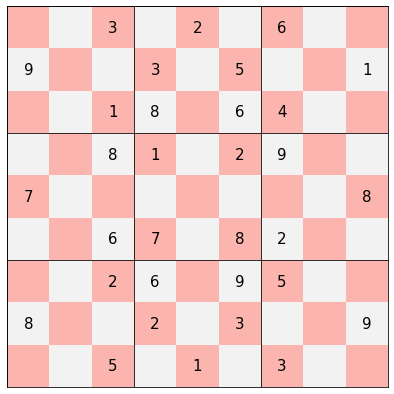

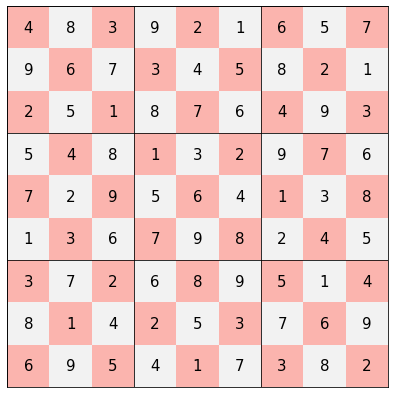


Solution found in 4 iterations
time taken to solve is 0.038979 seconds

Harder problem



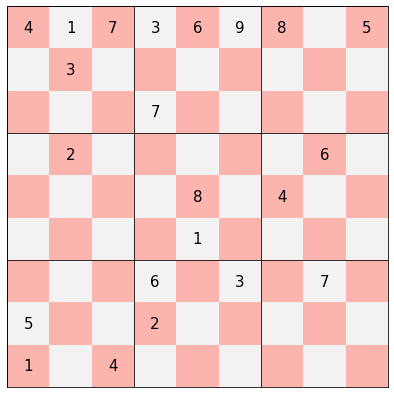

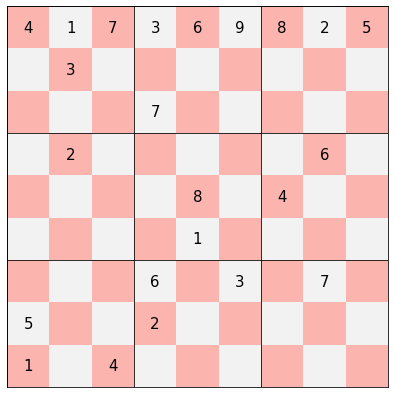


Solution not found after 2 iterations
time taken is 0.028677 seconds


(0.02867722511291504, False)

In [2]:
easy1 = '..3.2.6..9..3.5..1..18.64....81.29..7.......8..67.82....26.95..8..2.3..9..5.1.3..'
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
e = Sudoku(easy1)
e.display(e.infer_assignment())

implementAC1(e,pr=True)

print('\nHarder problem\n')
e = Sudoku(harder1)
e.display(e.infer_assignment())

implementAC1(e,pr=True)

## AC-3 <a name="ac3"></a>

### Definition <a name="ac3_definition"></a>
In AC-1, the domain of a variable is changed by deleting the values in the variable’s domain that are arc inconsistent with another variable. We notice that everytime the domain of the variable shrinks, some equivalent values in other variables now become inconsistent. AC-1 doesn’t take advantage of this and hence it must be run iteratively until the domain of all the variables don’t change. AC-3, on the contrary, tries to take advantage of this fact by using a queue that has information about the next arcs to be checked based on the modifications made in the current iteration. This leads to a much faster constraint propagation. The algorithm is described below

<img src="images/Algorithm_3.png">

### Complexity analysis of AC-3 <a name="ac3_complexity"></a>

Using the same notation as above, we can see that the size of the queue is $2*e$. Now for every element in the queue we apply the revise procedure which involves $k^{2}$ operations. Also in the worst case, everytime we perform a revise we might have to add k more values back to the queue. Therefore, in the worst case, we might have to perform $2*e*k^{2}*k$ steps in total. Therefore the worst case time complexity of AC-3 algorithm is $\mathcal{O}(ek^{3})$

### Example: solving Sudoku with AC-3 <a name="ac3_example"></a>

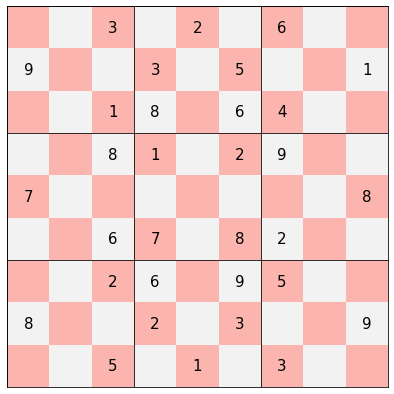

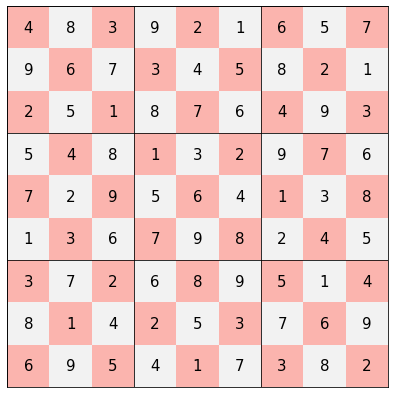

time taken to solve is 0.043224 seconds

Harder problem



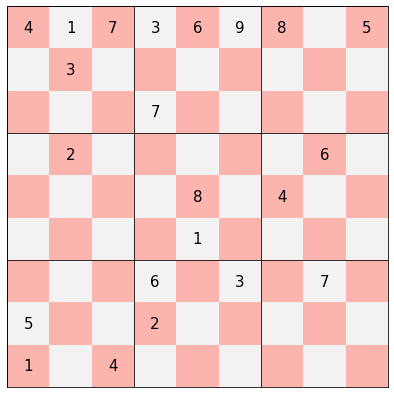

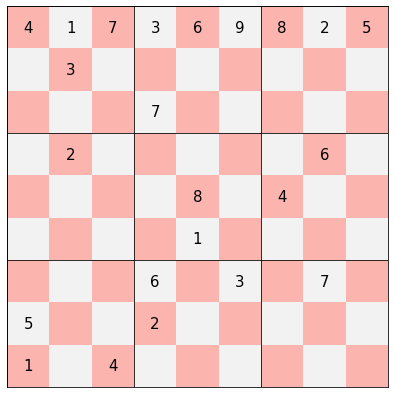


Solution not found
time taken is 0.058673 seconds


(0.05867290496826172, False)

In [3]:
easy1 = '..3.2.6..9..3.5..1..18.64....81.29..7.......8..67.82....26.95..8..2.3..9..5.1.3..'
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
e = Sudoku(easy1)
e.display(e.infer_assignment())

implementAC3(e,pr=True)

print('\nHarder problem\n')
e = Sudoku(harder1)
e.display(e.infer_assignment())

implementAC3(e,pr=True)

### Let's compare the average time complexity of AC-1 and AC-3

We have a file named easy50.txt which contains some 50 easy sudoku problems not all of which can be completely solved by constraint propagation. Let's measure the average time taken by both AC-1 and AC-3 on those problems that can be completely solved.

It can be seen from the previous two code blocks that AC-1 performs faster than AC-3 but we also proved that AC-3 has better worst case time complexity than AC-1. To understand this, observe that the average time taken by AC-3 is higher but the worst case time is better for AC-3.

In [ ]:
fname = './sudoku_files/easy50.txt'
problems = text2problem(fname)
length = len(problems)
t_1 = 0
t_2 = 0
in_1 = 0
in_2 = 0
max1 = 0
max2 = 0
for i in problems:
    t1, done1 = implementAC1(Sudoku(i),pr=False)
    t2, done2 = implementAC3(Sudoku(i),pr=False)
    if done1 == True:
        if max1 < t1:
            max1 = t1
        t_1 += t1
        in_1 += 1
    if done2 == True:
        if max2 < t2:
            max2 = t2
        t_2 += t2
        in_2 += 1
        
print('%d problems out of %d were solved'%(in_1,length))
print()
print('The average time taken by AC-1 algorithm is %f seconds' %(t_1/in_1))
print('The average time taken by AC-3 algorithm is %f seconds' %(t_2/in_2))
print()
print('The worst case performance for AC-1 algorithm was %f seconds' %max1)
print('The worst case performance for AC-3 algorithm was %f seconds' %max2)

## <a name="search_in_csps"></a>2. Search in CSPs

Constraint propagation alone is not sufficient to solve many CSPs. In this case, a solution must be found using **search algorithms**.

In this section, we will explain different search algorithms used to solve CSPs.
The section is organized as follows:

a. [Generic Search](#generic_search):
    * Formulating CSPs as a state space search problem
    * Complexity
    * Example: NQueens with generic search (5 Queens)
b. [Backtracking Search (BT)](#backtracking):
    * Definition
    * Complexity
    * Example: solving NQueens (15 Queens)
c. [Backtracking Search with Forward Checking (BT-FC)](#backtracking_w_fc):
    * Definition
    * Complexity
    * Example: solving NQueens (30 Queens)              
d. [**Backtracking while Maintaining Arc Consistency (BT-MAC)**](#backtracking_w_mac):
    * Definition
    * Complexity
    * Example: solving NQueens (30 Queens)
    
e. [Backtracking with Dynamic Variable Ordering](#bt_dvo):
    * [Definition](#bt_dvo_definition)
    * [Complexity](#bt_dvo_complexity)
    * [Example: solving NQueens (40 Queens)](#bt_dvo_example)
    * [Example: solving hard Sudokus](#bt_dvo_example_2)

### <a name="generic_search"></a> a. Generic Search

#### Formulating CSPs as a state space search problem <a name="generic_search_definition"></a> 

CSPs can be formulated using the State Space search representation.
In particular, we can express a CSP as follows:
* **State**:
    - We can define as state a **partial assignment** to variables made thus far.
    For example, if we have variables $A$, $B$ and $C$ whith respective domains $[a_1, a_2]$, $[b_1, b_2]$, and  $[c_1, c_2]$ a partial assignment would be for example $\{A=a_2, C=c_1\}$, another one could be $\{B=b_2, C=c_2\}$. In contrast, we consider a **complete assignment** one where all variables would be assigned, such as $\{A=a_2, B=b_1, C=c_1\}$. Note that a complete assignment is still a (kind-of) partial assignment.
* **Initial State**:
    - Initially the state would be **no assignment**, which we can represent as the empty set $\{\}$.
* **Operator/Action**:
    - We also need to define an action/operator to frame a CSP into a State Space search problem.
    In our case, this would correspond to the fact of **adding a new assignment**.
    In other words, our operator corresponds to the action of assigning a value to a yet unassigned variable $X=x$, which expands the State by one element. For example, if we start from the initial state $\{\}$, and we proceed with the action $X=x,$ we end up with a new state $\{X=x\}$, which is itself a partial assignment.
* **Goal Test**:
    - As in all State Space search problems, we need to define what is our goal state.
    In our case, this is achieved when all variables are assigned (meaning we have a **complete assignment**) and all constraints are satisfied (which we refer to as a **consistent assignment**).

Once the problem is formulated as a State Space search problem, we can use standard search algorithms such as:
* Breadth first search
* Depth first search
* Depth-limited search

to solve the given problem.

#### Complexity <a name="generic_search_complexity"></a>

Unfortunately, given a CSP with $n$ variables with a domain size of $d$, results in a branching factor at the top level of $nd$.
This is because any of the $n$ variables can be assigned any of $d$ values.
Once a variable has been assigned a value, we are still left with $n − 1$ variables which can be assigned $d$ values. By induction, we end up with a tree having $n!d^n ∼ \mathcal{O}((nd)^n)$ leaves, which is even larger than the possible $d^n$ complete assignments!

Nevertheless, we can observe than in a CSP **the order when assigning variables does not influence the solution**. This property is known as **commutativity**. More specifically, a problem is commutative if the order of application of any given set of actions does no effect on the outcome. Therefore, there is no need to consider all variables at each level of the search tree, but just one at a time. 

This makes sense intuitvely, for example, if we consider the coloring map problem, we might decide whether to color a certain region red or blue, but we would not decide between coloring one region red or another region blue. Therefore, the number of leaves is reduced to $d^n$, where we just have to decide on an assignment for each variable at a time.

#### Example: NQueens with generic search (5 Queens) <a name="generic_search_example"></a>

The N-queens puzzle is the problem of placing N chess queens on an N×N chessboard in a way such that no two queens threaten each other. Here N is a natural number. 

Thus, no two queens can share a common row, column, or diagonal. We will use the following representation in this problem.
- Each variable specifies the row on which a particular queen is placed. Each queen is identified (indexed) with a column of the board. This automatically ensures that the queens will not share columns.
- The variable domains are the available row indices.
- The constraints between the variables specify that the corresponding queens do not share a row or diagonal.

Using the State Space search formulation, we express the NQueens Problem as follows:
* **State**:
    - We can define as state a **partial assignment** of Queens (variables) made thus far.
* **Initial State**:
    - Initially the state would be **no assignment**, which, in our case, we represent as a value of -1 for all variables.
* **Operator/Action**:
    - Our action consists in **adding a new Queen** to the board.

In [ ]:
psource(NQueensProblem.actions)

* **Goal Test**:
    - This state is achieved when all variables are assigned (meaning we have a **complete assignment**) and all constraints are satisfied.

Below you can actually see the NQueens Problem coded as a State Search Problem:

In [ ]:
psource(NQueensProblem.goal_test)

Let us apply a generic search algorithm to the NQueens problem.
For example, let us use Depth First Search to find a solution.
Note that we are already applying the commutativity property of CSPs that we discussed previously.
Therefore, we are avoiding $n!$ redundant paths, thereby making the depth first search faster.

Feel free to change the number of queens used, but be aware that depth first search will start struggling with numbers larger than 7.

In [ ]:
N = 5

n_queens_problem = NQueensProblem(N, pruning=False)

start_time = time.time()
solution = depth_first_tree_search(n_queens_problem).solution()
end_time = time.time()
print("Time taken to solve %s Queens problem using Backtracking: %f seconds"% (N, end_time - start_time))

plot_NQueens(solution)

While the previous call to depth first search retrieved an answer in less than 5ms.
Check out what happens when N is higher!

In [ ]:
N = 7

n_queens_problem = NQueensProblem(N, pruning=False)

start_time = time.time()
solution = depth_first_tree_search(n_queens_problem).solution()
end_time = time.time()
print("Time taken to solve %s Queens problem using Backtracking: %f seconds"% (N, end_time - start_time))

plot_NQueens(solution)

It is starting to take some time to solve the problem. The reader can convince itself that with 8 or more Queens, it will take a long time to retrieve the solution.

### <a name="backtracking"></a> b. Backtracking

#### Definition <a name="backtracking_definition"></a> 

Backtracking search suits the commutative property of CSPs, as it consists on a depth-first search that chooses one variable at a time. 

Moreover, it makes use of another property of CSPs that is: **extensions to inconsistent partial assignments are always inconsistent**.
The backtracking search **backtracks** when an inconsistent partial assignment is reached. 

We show below the actual backtracking search algorithm (pseudo-code), as presented in Chapter 6 Constraint Satisfaction Problems of the book _Artificial Intelligence: A Modern Approach_. 

<a name="backtracking_algorithm"></a>
<img src="images/backtracking_algorithm.png" alt="drawing" width="600">

In plain words, the algorithm first chooses an unassigned variable, and loops over its domain by picking one value at
a time. Every time a value is taken, if it is consistent, then the algorithm continues to look for a
solution. If it is not consistent, then the algorithm backtracks by trying with another value instead.

The backtracking algorithm presented above makes use of a set of sub-functions that we detail
below:
* **Select-Unassigned-Variable(csp, assignment)**:
    - Decides which variable should be assigned next.
* **Order-Domain-Values(var, assignment, csp)**:
    - Decides the order in which the values of the variable should be tried. We will see in section 2.3.4 how modifications of this and the previous function result in different general purpose heuristics.
* **Inference(csp, var, assignment)**:
    - Every time a variable has been assigned a value, there is the opportunity to further reduce the domains of the rest of unassigned variables using inference, such as checking for arcconsistency. While the call to this function is not strictly necessary, we will see in section 2.3.3 that interleaving search and inference results in a more efficient algorithm.


    
The source code to implement this pseudo-code is actually fairly close to the actual implementation.
Find below the actual source code in python:

In [ ]:
psource(backtracking_search)

<a name="backtrack_pseudo"></a>

#### Example: solving NQueens using simple backtracking algorithm <a name="backtracking_example"></a> 

We can encode the NQueens problem as follows, for a N×N board:
* **Variables**:
    * Each of the Queen's positions on the board: $X_i = \text{row of queen in column i}$
* **Domains**:
    * The domain of each variable is just the number of rows on the board: $X_i \in \mathcal{X} = \{0, ..., N-1\}$
* **Constraints**:
    * Queens do not share rows. This is equivalent to requiring all variables $X_i$ to be of different value: $AllDiff(X_i)$
    * Only one queen in a column. This is satisfied by default because of the variable encoding.
    * No two queens can share a common diagonal. This can be encoded as follows:
         - Assume we have a variable $X_i$, or, in other words, a queen in the row given by the value of $X_i$ and column given by the index $i$.
         Then, no queen can be represented by $X_k$ if the following condition holds: $X_k = X_i - (k - i)$.
         This is only for diagonals going _down_ from left to right.
         What about the other diagonal? The one going _up_ from left to right can be similarly encoded changing just one sign: $X_k = X_i + (k - i)$. Since we need to check this constraint for all the queens on the board, we have:
             ```pseudo
                for all X_i:
                    for 0:k, k != i, k < N:
                       X_k != X_i - (k - i)
                       X_k != X_i + (k - i)
            ```

            But this is actually equivalent to check that the value of $X_k - k$ is different for all $k$ (same for  $X_k + k$)! Therefore, we can use the $AllDiff(\cdot)$ function to encode this constraint as well.
        
 Below you can find the actual NQueens problem formulated as explained here.
 Note that we define the variables and domains.
 Also, the constraints are encoded in the method `is_consistent` below.
This method checks that an assignment is consistent given the constraints, as required by the function `csp.is_consistent(var, val, assignment)` in the [backtrack code](#backtrack_pseudo).

In [ ]:
psource(NQueensCSP)

Note that the NQueensCSP inherits from a CSP.

In [ ]:
psource(CSP)

Now, let us solve the problem using backtracking!

In [ ]:
# Create NQueens problem.
N = 10
n_queens_backtracking = NQueensCSP(N)

# Solve the problem using Backtracking. Display timing.
start_time = time.time()
solution = backtracking_search(n_queens_backtracking)
end_time = time.time()
print("Time taken to solve %s Queens problem using Backtracking: %f seconds"% (N, end_time - start_time))
plot_NQueens(solution)


Backtracking is solving the problem way faster than Depth First Search (DFS)!
In particular for the 7 queens problem, DFS took $0.311423$ seconds to solve the problem.
Instead, backtracking only takes $0.000920$ seconds! Quite an improvement right?

### Run the snippet below to have an insight on how backtracking actually proceeds:
- We display with **red crosses** the domains that are not considered by the algorithm anymore (while this is not used for backtracking explicitly, we will see that for backtracking with forward checking we actually preemptively prune domains).
- Below we represent **any intermediate queen assignment by actually putting a queen on the board**. Note that every backtracking is just shown by removing a previously placed queen!
- When an assigned queen conflicts with a previously placed queen, we color the **square of the conflicting queens in red**.

**Use the ```iteration``` slider to see the intermediate steps that backtracking takes**. Mind that, due to visualization lag, you might need to leave the slider at a certain value for a minimum time in order to refresh the screen, so we do not recommend using the mouse, but you should rather **use left/right arrow keys**.

> If you see the board displaying things without responding to the slider, just interrupt the kernel (black square in the toolbar, next to the Run command) and run the cell again.

In [ ]:
# Create NQueens problem.
N = 10
n_queens_backtracking = NQueensCSP(N)
backtracking_instru_queen = make_instru(n_queens_backtracking)
result = backtracking_search(backtracking_instru_queen)

# Displaying
display_nqueens(backtracking_instru_queen, result)

### <a name="backtracking_w_fc"></a> c. Backtracking with Forward Checking

#### Definition <a name="bt_fc_definition"></a>

By modifying the call to the function _Inference_ in the backtracking algorithm presented [above](#backtracking_algorithm), we can interleave search with inference to reduce the domain of yet unassigned variables, thereby reducing the search space. 

A simple form of inference is **forward checking**, which consists in establishing arc-consistency for the recently assigned variable with respect to all connected, yet unassigned, variables.

#### Complexity <a name="bt_fc_complexity"></a>

Forward checking only checks arc-consistency for arcs that terminate on the new assignment.
Therefore, it has a $\mathcal{O}(ek)$ complexity, where $k$ is the domain's size and $e$ are the number of binary constraints.

#### Example: NQueens <a name="bt_fc_example"></a>

Checking arc-consistency for the NQueens problem is simple, as we just need to define a function 
The constraint that needs to be passed to the CSP is defined in the **queen_constraint** function. 
The constraint is satisfied (true) if A, B are really the same variable, or if they are not in the same row (equivalent to having the same value), down diagonal, or up diagonal.

In [ ]:
psource(queen_constraint)

In [ ]:
# Create NQueens problem.
N = 15
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking with Forward Checking (fc flag set to True). Store timing.
start_time = time.time()
solution = backtracking_search(n_queens, inference = forward_checking)
end_time = time.time()
print(" Time taken to solve %s Queens problem using Backtracking with Forward Checking: %f seconds"% (N, end_time - start_time))
plot_NQueens(solution)

### Run the snippet below to have an insight on how backtracking with forward checking actually proceeds:
As before:
- We display with **red crosses** the domains that are not considered by the algorithm anymore (while this is not used for backtracking explicitly, we will see that for backtracking with forward checking we actually preemptively prune domains).
- Below we represent **any intermediate queen assignment by actually putting a queen on the board**. Note that every backtracking is just shown by removing a previously placed queen!
- When an assigned queen conflicts with a previously placed queen, we color the **square of the conflicting queens in red**.

On top of this, **we now display if a domain is pruned to the point where there is no possible values by coloring the column of the offending variable in _yellow_**.

**Use the ```iteration``` slider to see the intermediate steps that backtracking with forward checking takes**. Mind that, due to visualization lag, you might need to leave the slider at a certain value for a minimum time in order to refresh the screen.

> If you see the board displaying things without responding to the slider, just interrupt the kernel (black square in the toolbar, next to the Run command) and run the cell again.

Here we use a small N because it is easier to observe the actual behaviour of the algorithm.

In [ ]:
# Create small NQueens problem.
N = 10
n_queens = NQueensCSP(N)

# This is to store the intermediate steps.
backtracking_instru_queen = make_instru(n_queens)

# Solve it using backtracking with forward checking.
result = backtracking_search(backtracking_instru_queen, inference = forward_checking)

# Displaying
display_nqueens(backtracking_instru_queen, result)

### <a name="backtracking_w_mac"></a>d. Backtracking while Maintaining Arc Consistency (BT-MAC)

#### Definition <a name="bt_mac_definition"></a>

We have seen that forward checking allows us to prune domains of variables that otherwise would be in conflict with the newly added queen. Nevertheless, forward checking does not actually ensure arc-consistency for all the variables.

The idea of the inference algorithm _Maintaining Arc Consistency_ (MAC) is to run the AC3 algorithm we discussed [here](#AC-3-) every time we assign a new queen. This ensures that we do not continue down a possible partial assignment which will lead to a dead end. Effectively, the search space gets reduced!

We can observe this behaviour very clearly by using the interactive slider to visualize intermediate steps.
Below we show both boards at iteration number 3 for both algorithms.
We can see that, while forward checking is unable to see that this partial assigment is actually not arc-consistent, _Maintaining Arc Consistency_ infers that we should already backtrack as this partial assignment will lead us to a dead-end.

| <p align="center">Forward Checking: | <p align="center">Maintaining Arc Consistency:|
|:-------------------------:|:-------------------------:|
|![alt-text-1](images/bt-fc.png "title-1") | ![alt-text-2](images/bt-mac.png "title-2")|

Below is the actual code for MAC:

In [ ]:
psource(mac)

#### Complexity <a name="bt_mac_complexity"></a>
By ensuring full arc-consistency between all variables each time a queen is placed on the board, MAC is strictly more computationally demanding than Forward Checking.
While Forward Checking has a complexity of $\mathcal{O}(ek)$, full AC3 propagation is $\mathcal{O}(ek^3)$, where $k$ is the domain's size and $e$ are the number of binary constraints.
Yet, by pruning the search tree further than Forward Checking, MAC uses less iterations to arrive to a solution.

Therefore, whether MAC has a better or worst runtime performance than Forward Checking depends on the actual cost of doing constraint propagation versus search.
That is why backtracking with Forward Checking, or even simple backtracking, are still used in applications.

In our case, we actually observe that MAC takes about $0.10$ seconds to solve the 15 queens problem, while Forward Checking only takes half of this: $0.05$ seconds. For reference, simple backtracking takes $0.50$ seconds instead for the same problem.

In terms of actual iterations (and we refer to an iteration as any assignment or unassignment of a variable), we observe the following for the N = 15 queens problem:
- Backtracking with Forward Checking: $135$ iterations
- Backtracking with MAC: $41$ iterations

#### Example: solving NQueens (20 Queens) <a name="bt_mac_example"></a>


In [ ]:
# Create NQueens problem.
N = 15
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking with Forward Checking. Store timing.
start_time = time.time()
solution = backtracking_search(n_queens, inference = mac)
end_time = time.time()
print(" Time taken to solve %s Queens problem using Backtracking with MAC: %f seconds"% (N, end_time - start_time))
plot_NQueens(solution)

### Run the snippet below to have an insight on how backtracking with Maintaining Arc Consistency actually proceeds:
We use below the same legend as before to represent pruned domains, partial assignments and empty domains.

**Use the ```iteration``` slider to see the intermediate steps that backtracking with Maintaining Arc Consistency takes**. Mind that, due to visualization lag, you might need to leave the slider at a certain value for a minimum time in order to refresh the screen.

> If you see the board displaying things without responding to the slider, just interrupt the kernel (black square in the toolbar, next to the Run command) and run the cell again.

Here we use a small N because it is easier to observe the actual behaviour of the algorithm.

In [ ]:
# Create small NQueens problem.
N = 10
n_queens = NQueensCSP(N)

# This is to store the intermediate steps.
backtracking_instru_queen = make_instru(n_queens)

# Solve it using backtracking with forward checking.
result = backtracking_search(backtracking_instru_queen, inference = mac)

# Displaying
display_nqueens(backtracking_instru_queen, result)

### e. Backtracking with Dynamic Variable Ordering <a name="bt_dvo"></a>
#### Definition  <a name="bt_dvo_definition"></a>
So far we have used the backtracking algorithm presented [before](#backtracking_algorithm) using as function for ```Selected-Unassigned-Variable``` a static variable ordering where we pick variables in order.
For the NQueens problem, we were picking first the first column, then the second, etc.

An alternative approach is to dynamically pick the next variable to assign using heuristics.
Here we present the **Minimum-Remaining-Values (MRV)** heuristic which picks as next variable the one for which its domain is the smallest. This heuristic has also been called the "most constrained variable" or the "fail-first" heuristic.

#### Complexity <a name="bt_dvo_complexity"></a>

The MRV heuristic can perform better than a random or static ordering, but results vary wieldly depending on the problem.

#### Example: solving NQueens (40 Queens) <a name="bt_dvo_example"></a>

For the NQueens problem, using the MRV heuristic allows us to solve much larger problems than with a static ordering.
We can, for example, solve a 40 Queens problem (or even 80 Queens problem) in "real-time".


In [ ]:
# Create NQueens problem.
N = 40
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking with Forward Checking. Store timing.
start_time = time.time()
solution = backtracking_search(n_queens, select_unassigned_variable=mrv, inference = mac)
end_time = time.time()
print(" Time taken to solve %s Queens problem using Backtracking with MAC: %f seconds"% (N, end_time - start_time))
plot_NQueens(solution)

**Run the snippet below to have an insight on how backtracking with MAC and MRC works:**

In [ ]:
# Create small NQueens problem.
N = 10
n_queens = NQueensCSP(N)

# This is to store the intermediate steps.
backtracking_instru_queen = make_instru(n_queens)

# Solve it using backtracking with forward checking.
result = backtracking_search(backtracking_instru_queen,select_unassigned_variable=mrv, inference = mac)

# Displaying
display_nqueens(backtracking_instru_queen, result)

#### Example: solving hard Sudokus <a name="bt_dvo_example_2"></a>
We saw before that we cannot solve hard Sudokus by just using [AC3]().
Here we show that combining MAC inference with MRV variable ordering we can easily solve the Sudoku we had issues with at the beginning.

In [ ]:
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
h = Sudoku(harder1)
h.display(h.infer_assignment())
print()
solution = backtracking_search(h, select_unassigned_variable=mrv, inference=forward_checking)
h.display(solution)

### d. Empirical runtime comparison between Forward Checking and Maintaining Arc Consistency <a name="experiments"></a>

As we have mentioned before, MAC is slightly slower per node than Forward Checking, yet it can often perform reasoning steps which remove large parts of the search space.

Experimentally, we observe the following results for the NQueens and Sudoku problems (using the MRV heuristic as variable ordering):

- 60 Queens :

| Algorithm| Runtime (s)|
|:-------|-------|
|FC| 0.345 |
|MAC|2.926 |
    

- Hard Sudoku :

| Algorithm |Runtime (s)|
|:-------|-------|
|FC| 0.013|
|MAC|0.066|

In [ ]:
# Create NQueens problem.
N = 60
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking with Forward Checking. Store timing.
start_time = time.time()
solution = backtracking_search(n_queens, select_unassigned_variable=mrv, inference = forward_checking)
end_time = time.time()
print(" Time taken to solve %s Queens problem using Backtracking with FC: %f seconds"% (N, end_time - start_time))

In [ ]:
# Create NQueens problem.
N = 60
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking with MAC. Store timing.
start_time = time.time()
solution = backtracking_search(n_queens, select_unassigned_variable=mrv, inference = mac)
end_time = time.time()
print(" Time taken to solve %s Queens problem using Backtracking with MAC: %f seconds"% (N, end_time - start_time))

In [ ]:
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
h = Sudoku(harder1)
start_time = time.time()

# Solve the problem using Backtracking with Forward Checking. Store timing.
solution = backtracking_search(h, select_unassigned_variable=mrv, inference=forward_checking)
end_time = time.time()
print(" Time taken to solve hard Sudoku problem using Backtracking with FC: %f seconds"% (end_time - start_time))

In [ ]:
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
h = Sudoku(harder1)
start_time = time.time()

# Solve the problem using Backtracking with MAC. Store timing.
solution = backtracking_search(h, select_unassigned_variable=mrv, inference=mac)
end_time = time.time()
print(" Time taken to solve hard Sudoku problem using Backtracking with MAC: %f seconds"% (end_time - start_time))

## Bucket Elimination

The idea of join and project used to eliminate variables when solving system of linear equation can be extended to constraints. This is made possible by bucket elimination. 

$\textbf{Join operation}$ for constraints is shown below:
<img src="images/pic_1.png">

$\textbf{Project operation}:$ C2 = $\pi_{2}C_{21}$
<img src="images/pic_2.png">

Important ideas behind bucket elimination are as follows:

* Eliminate: Derive all consequences that depend on each Vi
    by joining all constraints involving Vi

* Solve: Encode all solutions to constraints $\phi$,
    by systematically eliminating all variables.

* Generate: all solutions without backtrack search, by propagating.